# Train Pitch Type Prediction Model

Starting with the most simplicistic prediction, the goal with this experiment is to predict whether a pitcher will pitch a ball or a strike, given a basic game scenario.

Ideas for getting better accuracy:
- Filter data based on pitcher (and catcher?).  Do not think this will work because of model training aspect - not transactional.
- Is the game packed or is it empty?
- Is it at night?
- Is it cold?
- Is it raining?

In [3]:
print(locals())

{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "metrics_output = None\ntry:\n    metrics_output = globals()['metrics_output']\nexcept KeyError:\n    pass", 'print (globals())', 'print(locals())'], '_oh': {}, '_dh': [PosixPath('/opt/app-root/src/baseball/data/src/train')], 'In': ['', "metrics_output = None\ntry:\n    metrics_output = globals()['metrics_output']\nexcept KeyError:\n    pass", 'print (globals())', 'print(locals())'], 'Out': {}, 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f37da632450>>, 'exit': <IPython.core.autocall.ZMQExitAutocall object at 0x7f37da642c50>, 'quit': <IPython.core.autocall.ZMQExitAutocall object at 0x7f37da642c50>, 'open': <function open at 0x7f37ec1a60c0>, '_': '', '__

In [2]:
print (globals())

{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "metrics_output = None\ntry:\n    metrics_output = globals()['metrics_output']\nexcept KeyError:\n    pass", 'print (globals())'], '_oh': {}, '_dh': [PosixPath('/opt/app-root/src/baseball/data/src/train')], 'In': ['', "metrics_output = None\ntry:\n    metrics_output = globals()['metrics_output']\nexcept KeyError:\n    pass", 'print (globals())'], 'Out': {}, 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f37da632450>>, 'exit': <IPython.core.autocall.ZMQExitAutocall object at 0x7f37da642c50>, 'quit': <IPython.core.autocall.ZMQExitAutocall object at 0x7f37da642c50>, 'open': <function open at 0x7f37ec1a60c0>, '_': '', '__': '', '___': '', '__session__': '/opt

In [26]:
metrics_output = None
try:
    metrics_output = locals()['metrics_output']
except KeyError:
    pass

if metrics_output is not None:
    print ("KFP metric output was found.  Will log output metrics at the end of the process")
else:
    print ("KFP metric output not found.")
    raise ValueError("FAIL")

KFP metric output not found.


In [4]:
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from train_tools import SCALER_SUFFIX

from train_tools import acquire_data, drop_column
from train_tools import scale_int_values, extract_categorical_columns
from train_tools import replace_populated_values_with_tf_num, replace_boolean_values_with_tf_num
from train_tools import model_train, save_model, evaluate_model

In [5]:
output_dir = "../../../target/models/predict_pitch/"
onnx_path = os.path.join(output_dir, "model.onnx")
roc_path = os.path.join(output_dir, "roc.jpg")
dataset_size = 5000
db_conn_str = "postgresql://baseball_app:baseball123@db/baseball_db"
neural_network_width = 10


In [6]:
output_dir = os.path.abspath(output_dir)
print ("Output Directory: " + output_dir)

# ensure the model directory exists
if not os.path.exists(output_dir):
    print ("Creating output directory: " + output_dir)
    os.makedirs(output_dir)

Output Directory: /opt/app-root/src/baseball/target/models/predict_pitch


## Acquire Data

Pull relevant attributes from the baseball database as a DataFrame for analysis and training.

In [7]:
if dataset_size is not None and isinstance(dataset_size, str) and len(dataset_size) > 0:
    dataset_size = int(dataset_size)
print ("Data Set Size: " + str(dataset_size))

Data Set Size: 5000


In [8]:
sql = """
        select random() as r_id, game_play_atbat.player_code as player_code, pitch_index, pitch_type.pitch_type_cd as pitch_type_cd, home_team_flag, game_play_atbat.score_home as score_home, game_play_atbat.score_visitor as score_visitor, sky, night_flag, temperature, wind_direction, wind_speed, precipitation, field_condition, roster_batter.batting_hand as batting_hand, roster_pitcher.throw_hand as pitching_hand, runner_1b, runner_2b, runner_3b, ball_or_strike, pitch_count
        from game, game_play, game_play_atbat, game_play_atbat_pitch, roster as roster_batter, roster as roster_pitcher, pitch_type
        where game.game_id = game_play.game_id
        and game_play_atbat.game_play_id = game_play.game_play_id
        and game_play_atbat_pitch.game_play_id = game_play.game_play_id
        and roster_batter.player_code = game_play_atbat.player_code
        and roster_batter.season_year = date_part('year', game.game_date)
        and roster_pitcher.player_code = game_play_atbat.pitcher
        and roster_pitcher.season_year = roster_batter.season_year
        and pitch_type.pitch_type_cd = game_play_atbat_pitch.pitch_type_cd
        and pitch_type.ball_or_strike is not null
        order by r_id  
      """

full_df = acquire_data(db_conn_str, sql, dataset_size)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   r_id             5000 non-null   float64
 1   player_code      5000 non-null   object 
 2   pitch_index      5000 non-null   int64  
 3   pitch_type_cd    5000 non-null   object 
 4   home_team_flag   5000 non-null   bool   
 5   score_home       5000 non-null   int64  
 6   score_visitor    5000 non-null   int64  
 7   sky              5000 non-null   object 
 8   night_flag       5000 non-null   bool   
 9   temperature      5000 non-null   int64  
 10  wind_direction   5000 non-null   object 
 11  wind_speed       5000 non-null   int64  
 12  precipitation    5000 non-null   object 
 13  field_condition  5000 non-null   object 
 14  batting_hand     5000 non-null   object 
 15  pitching_hand    5000 non-null   object 
 16  runner_1b        2059 non-null   object 
 17  runner_2b     

In [9]:
def calculate_score_deficit(row):
    is_home = row["home_team_flag"]
    score_home = row["score_home"]
    score_visitor = row["score_visitor"]

    if is_home:
        return score_home - score_visitor
    else:
        return score_visitor - score_home

full_df['score_deficit'] = full_df.apply(lambda x: calculate_score_deficit(x), axis=1)

In [10]:
full_df.head()

,r_id,player_code,pitch_index,pitch_type_cd,home_team_flag,score_home,score_visitor,sky,night_flag,temperature,...,precipitation,field_condition,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,ball_or_strike,pitch_count,score_deficit
0,1.436166e-07,tatif001,1,C,False,8,2,unknown,True,54,...,unknown,unknown,R,R,wrigd002,coraa001,None,S,153,-6
1,3.283169e-07,wilse001,3,C,True,0,3,cloudy,False,64,...,unknown,unknown,R,L,None,None,None,S,32,-3
2,3.775446e-07,carav001,8,B,False,0,0,sunny,False,78,...,unknown,unknown,R,L,carav001,contw001,None,B,25,0
3,5.276632e-07,ramij003,4,B,False,2,2,overcast,True,78,...,unknown,unknown,R,R,ramij003,kipnj001,None,B,118,0
4,5.334811e-07,tulot001,3,F,False,3,8,overcast,True,71,...,unknown,unknown,R,L,None,None,None,S,107,5


## Prepare Data for Model Training

Prepare data for classification.

In [11]:
# focus data frame on prediction values
df = full_df[["pitch_index", "runner_1b", "runner_2b", "runner_3b", "home_team_flag", "score_deficit", 
              "night_flag", "pitch_count", "ball_or_strike"]]
df = df[df['ball_or_strike'].notnull()]

df = df.convert_dtypes()
df.head()

,pitch_index,runner_1b,runner_2b,runner_3b,home_team_flag,score_deficit,night_flag,pitch_count,ball_or_strike
0,1,wrigd002,coraa001,<NA>,False,-6,True,153,S
1,3,<NA>,<NA>,<NA>,True,-3,False,32,S
2,8,carav001,contw001,<NA>,False,0,False,25,B
3,4,ramij003,kipnj001,<NA>,False,0,True,118,B
4,3,<NA>,<NA>,<NA>,False,5,True,107,S


In [12]:
replace_populated_values_with_tf_num(df, 'runner_1b', 'is_runner_1b', True)
replace_populated_values_with_tf_num(df, 'runner_2b', 'is_runner_2b', True)
replace_populated_values_with_tf_num(df, 'runner_3b', 'is_runner_3b', True)

replace_boolean_values_with_tf_num(df, "home_team_flag", 'is_home', True)
replace_boolean_values_with_tf_num(df, "night_flag", 'is_night', True)

scale_int_values(df, 'score_deficit', 'score_deficit_scaled', True, 
                 output_dir + "/" + "score_deficit" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_count', 'pitch_count', False,
                 output_dir + "/" + "pitch_count" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_index', 'pitch_index', False,
                 output_dir + "/" + "pitch_index" + SCALER_SUFFIX)

df.head()


,pitch_index,pitch_count,ball_or_strike,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled
0,-1.081262,1.674924,S,1,1,0,0,1,-1.806295
1,-0.045570,-0.915279,S,0,0,0,1,0,-0.896231
2,2.543659,-1.065126,B,1,1,0,0,0,0.013833
3,0.472275,0.925691,B,1,1,0,0,1,0.013833
4,-0.045570,0.690218,S,0,0,0,0,1,1.530607


In [13]:
df = extract_categorical_columns(df, ["ball_or_strike"])
drop_column(df, "ball_or_strike_B")
df.rename(columns={'ball_or_strike_S': 'is_strike'}, inplace=True)

df.head()

,pitch_index,pitch_count,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled,is_strike
0,-1.081262,1.674924,1,1,0,0,1,-1.806295,True
1,-0.045570,-0.915279,0,0,0,1,0,-0.896231,True
2,2.543659,-1.065126,1,1,0,0,0,0.013833,False
3,0.472275,0.925691,1,1,0,0,1,0.013833,False
4,-0.045570,0.690218,0,0,0,0,1,1.530607,True


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pitch_index           5000 non-null   float64
 1   pitch_count           5000 non-null   float64
 2   is_runner_1b          5000 non-null   int64  
 3   is_runner_2b          5000 non-null   int64  
 4   is_runner_3b          5000 non-null   int64  
 5   is_home               5000 non-null   int64  
 6   is_night              5000 non-null   int64  
 7   score_deficit_scaled  5000 non-null   float64
 8   is_strike             5000 non-null   boolean
dtypes: boolean(1), float64(3), int64(5)
memory usage: 322.4 KB


In [15]:
df["is_strike"].describe()

count     5000
unique       2
top       True
freq      3168
Name: is_strike, dtype: object

## Train Model

Train a classification model using the prepared data set.

In [16]:
num_features = df.shape[1] - 1
print(f"Number of Features: {num_features}")

print("Columns and their respective order for inferences:")
df.columns[0:num_features]

Number of Features: 8
Columns and their respective order for inferences:


Index(['pitch_index', 'pitch_count', 'is_runner_1b', 'is_runner_2b',
       'is_runner_3b', 'is_home', 'is_night', 'score_deficit_scaled'],
      dtype='object')

In [17]:
# Extract data
X = df.iloc[:, 0:num_features]
y = df.iloc[:, num_features:]

# Convert to 2D PyTorch tensors
Xt = torch.tensor(X.values, dtype=torch.float32)
yt = torch.tensor(y.values, dtype=torch.float32)

In [18]:
class PitchPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(num_features, num_features*neural_network_width)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(num_features*neural_network_width, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.7, shuffle=True)

print ("Training Shapes: ")
print ()
print ("X_train = " + str(list(X_train.size())))
print ("y_train = " + str(list(y_train.size())))
print ("X_test = " + str(list(X_test.size())))
print ("y_test = " + str(list(y_test.size())))

Training Shapes: 

X_train = [3500, 8]
y_train = [3500, 1]
X_test = [1500, 8]
y_test = [1500, 1]


In [20]:
model = PitchPredictionModel()
final_acc = model_train(model, X_train, y_train, X_test, y_test)

print(f"Final model accuracy: {final_acc*100:.2f}%")

Epoch 49: 100%|██████████| 350/350 [00:03<00:00, 109.33batch/s, acc=0.8, loss=0.427]


Final model accuracy: 63.93%


ROC Image Output Filename: /opt/app-root/src/baseball/target/models/predict_pitch/roc.jpg
[-1.0812622  -1.4076318   0.          0.          1.          0.
  0.          0.01383298] -> [0.6486692] (expected [1.])
[ 1.5079672   1.8033633   1.          1.          0.          1.
  0.         -0.28952175] -> [0.55450606] (expected [1.])
[-0.56341636  0.73303163  1.          0.          0.          0.
  0.          0.6205424 ] -> [0.5784445] (expected [1.])
[-1.0812622  0.2620857  0.         0.         0.         0.
  1.         0.3171877] -> [0.61742175] (expected [1.])
[ 0.47227547 -0.50855315  1.          0.          0.          0.
  0.          0.3171877 ] -> [0.57868475] (expected [1.])


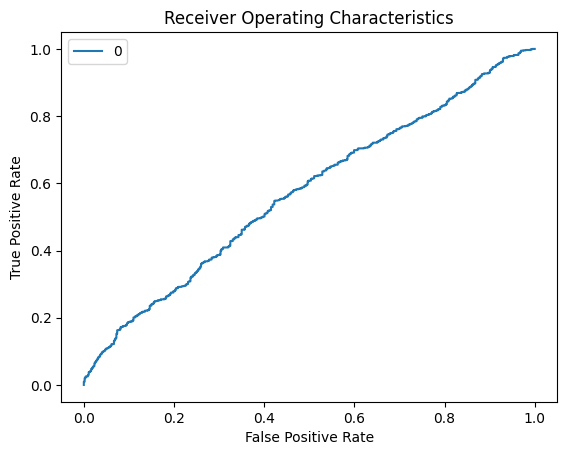

KFP not detected.  Skipping metrics logging.
{'__name__': 'train_tools', '__doc__': ' Utility methods for use by prediction services. ', '__package__': '', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7f364c942590>, '__spec__': ModuleSpec(name='train_tools', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f364c942590>, origin='/opt/app-root/src/baseball/data/src/train/train_tools.py'), '__file__': '/opt/app-root/src/baseball/data/src/train/train_tools.py', '__cached__': '/opt/app-root/src/baseball/data/src/train/__pycache__/train_tools.cpython-311.pyc', '__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with

In [21]:
roc_path = os.path.abspath(roc_path)
print("ROC Image Output Filename: " + roc_path)

evaluate_model(model, X_test, y_test, roc_path, metrics_output)

## Save the model

Save the model to disk for use by an inference service.

In [22]:
onnx_path = os.path.abspath(onnx_path)
print ("ONNX Model Output Filename: " + onnx_path)

save_model(model, num_features, onnx_path)

ONNX Model Output Filename: /opt/app-root/src/baseball/target/models/predict_pitch/model.onnx
